In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install numpy scikit-learn
!pip install -q torch_geometric
!pip install -q class_resolver
!pip3 install pymatting
!pip install opencv-python
!pip install matplotlib
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 1.7 MB/s eta 0:00:00


In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
import torch
import torch.nn as nn
import torch.nn.functional as nnFn
import torch.optim as optim
import numpy as np
import random
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import TensorDataset, DataLoader, Subset
from torch_geometric.data import Data
from torch.utils.data import TensorDataset, DataLoader, Subset
from torchvision import models

In [5]:
import torch
print("CUDA available:", torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

CUDA available: True
GPU Name: NVIDIA RTX A4000


In [4]:
data = np.load('/home/snu/Downloads/pneumoniamnist_224.npz', allow_pickle=True)
all_images = np.concatenate([data['train_images'], data['val_images'], data['test_images']], axis=0)
all_labels = np.concatenate([data['train_labels'], data['val_labels'], data['test_labels']], axis=0).squeeze()

# Convert to 3-channel RGB
images = all_images.astype(np.float32) / 255.0
images = np.repeat(images[:, None, :, :], 3, axis=1)  # (N, 3, 224, 224)
X_torch = torch.tensor(images)
y_torch = torch.tensor(all_labels).long()

print(f"Raw images: {X_torch.shape}, Labels: {y_torch.shape}")

Raw images: torch.Size([5856, 3, 224, 224]), Labels: torch.Size([5856])


In [6]:
class0_idx = [i for i in range(len(y_torch)) if y_torch[i] == 0]
class1_idx = [i for i in range(len(y_torch)) if y_torch[i] == 1]

random.seed(42)
sampled_class0 = random.sample(class0_idx, min(2000, len(class0_idx)))
sampled_class1 = random.sample(class1_idx, min(2000, len(class1_idx)))

selected_indices = sampled_class0 + sampled_class1
random.shuffle(selected_indices)

subset_dataset = Subset(TensorDataset(X_torch, y_torch), selected_indices)
subset_loader = DataLoader(subset_dataset, batch_size=64, shuffle=False)

In [7]:
resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Identity()
resnet = resnet.to(device)
resnet.eval()

resnet_feats = []
y_list = []
with torch.no_grad():
    for imgs, labels in subset_loader:
        imgs = imgs.to(device)
        feats = resnet(imgs)
        resnet_feats.append(feats.cpu())
        y_list.extend(labels.cpu().tolist())

features = torch.cat(resnet_feats, dim=0).numpy().astype(np.float32)  # shape (N, feat_dim)
y_labels = np.array(y_list).astype(np.float32)
print("Feature shape:", features.shape, "Label shape:", y_labels.shape)

/home/snu/anaconda3/envs/torch_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/snu/anaconda3/envs/torch_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Feature shape: (3583, 512) Label shape: (3583,)


In [9]:
scaler = StandardScaler()
X = scaler.fit_transform(features)

In [10]:
# Stratified split
sss = StratifiedShuffleSplit(n_splits=20, test_size=0.9, random_state=42)

In [11]:
# Storage for metrics
accuracies, precisions, recalls, f1_scores, losses = [], [], [], [], []

In [13]:
all_y_true = []
all_y_proba = []
all_fpr = []
all_tpr = []
all_auc = []

for fold, (train_idx, test_idx) in enumerate(sss.split(X, y_labels)):
    print(f"\nTraining fold {fold + 1}")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y_labels[train_idx], y_labels[test_idx]

    clf = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    loss = log_loss(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    losses.append(loss)
    all_y_true.extend(y_test)
    all_y_proba.extend(y_pred_proba)

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(auc_score)

    print(f"Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | Loss: {loss:.4f} | AUC: {auc_score:.4f}")

# Final average results
print("\nAverage Results across 20 folds:")
print(f"Accuracy: {np.mean(accuracies):.4f} \u00b1 {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} \u00b1 {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} \u00b1 {np.std(recalls):.4f}")
print(f"F1 Score: {np.mean(f1_scores):.4f} \u00b1 {np.std(f1_scores):.4f}")
print(f"Cross-Entropy Loss: {np.mean(losses):.4f} \u00b1 {np.std(losses):.4f}")
print(f"Average AUC: {np.mean(all_auc):.4f} \u00b1 {np.std(all_auc):.4f}")


Training fold 1
Accuracy: 0.9423 | Precision: 0.9659 | Recall: 0.9294 | F1: 0.9473 | Loss: 0.1513 | AUC: 0.9859

Training fold 2
Accuracy: 0.9355 | Precision: 0.9284 | Recall: 0.9583 | F1: 0.9431 | Loss: 0.1682 | AUC: 0.9836

Training fold 3
Accuracy: 0.9358 | Precision: 0.9482 | Recall: 0.9361 | F1: 0.9421 | Loss: 0.1603 | AUC: 0.9848

Training fold 4
Accuracy: 0.9355 | Precision: 0.9492 | Recall: 0.9344 | F1: 0.9418 | Loss: 0.1648 | AUC: 0.9837

Training fold 5
Accuracy: 0.9355 | Precision: 0.9512 | Recall: 0.9322 | F1: 0.9416 | Loss: 0.1718 | AUC: 0.9812

Training fold 6
Accuracy: 0.9467 | Precision: 0.9641 | Recall: 0.9394 | F1: 0.9516 | Loss: 0.1443 | AUC: 0.9870

Training fold 7
Accuracy: 0.9448 | Precision: 0.9496 | Recall: 0.9517 | F1: 0.9506 | Loss: 0.1576 | AUC: 0.9864

Training fold 8
Accuracy: 0.9336 | Precision: 0.9209 | Recall: 0.9639 | F1: 0.9419 | Loss: 0.1842 | AUC: 0.9829

Training fold 9
Accuracy: 0.9284 | Precision: 0.9351 | Recall: 0.9367 | F1: 0.9359 | Loss: 0.19

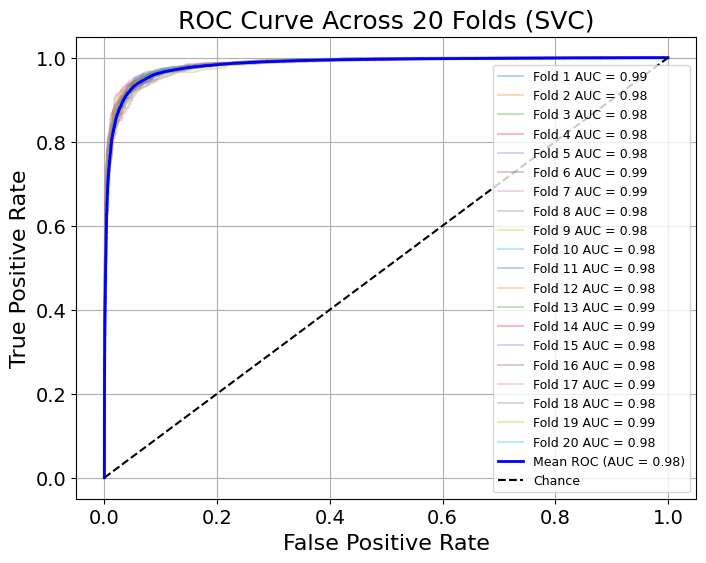

In [14]:
plt.figure(figsize=(8, 6))

for i in range(len(all_fpr)):
    plt.plot(all_fpr[i], all_tpr[i], alpha=0.3, label=f"Fold {i+1} AUC = {all_auc[i]:.2f}")

# Average ROC Curve
fpr_avg, tpr_avg, _ = roc_curve(all_y_true, all_y_proba)
auc_avg = roc_auc_score(all_y_true, all_y_proba)
plt.plot(fpr_avg, tpr_avg, color='blue', lw=2, label=f"Mean ROC (AUC = {auc_avg:.2f})")

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.title("ROC Curve Across 20 Folds (SVC)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)